<a href="https://colab.research.google.com/github/pulseq/MR-Physics-with-Pulseq/blob/main/tutorials/01_basic_sequences/notebooks/02_from_fid_to_se1d_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# from FID to 1D spin-echo (SE) sequence
Macroscopic field inhomogeneity is a bit annoying. We can use a refocusing RF pulse to reduce its effect and produce an echo, a.k.a. spin echo or Hahn echo:)   
**Exercise:**
1. This exercise starts from the single FID. Add a delay of a few ms between the RF and the ADC. Add a further RF event to create an echo in the ADC. Which flip angle generates the highest echo?
2.	Try to find a way so that the echo forms in the middle of the ADC. What is the general rule for the echo position in time?
3. Try to adjust RF phase offset / ADC phase offset to get (i) a real and negative echo, (ii) a real and positive echo.
4. (optional) Add more refocusing RF pulses and ADCs to retrieve the spin echo in every ADC. What is the numerical value of the decay rate of the echo peak? Is this T1, T2, or T2*?


In [1]:
#@title 1D SE in a pixel phantom - environment setup
!pip install git+https://github.com/FrankZijlstra/pypulseq.git@bugfixes
#!pip install git+https://github.com/imr-framework/pypulseq.git
!wget https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py &> /dev/null
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pypulseq as mr
# for simulation
!pip show MRzeroCore || pip install MRzeroCore
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/util.py &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null
import utils # several helper functions for simulation and recon
import MRzeroCore as mr0

  Cloning https://github.com/FrankZijlstra/pypulseq.git (to revision bugfixes) to /tmp/pip-req-build-kcw93f6d
  Running command git clone --filter=blob:none --quiet https://github.com/FrankZijlstra/pypulseq.git /tmp/pip-req-build-kcw93f6d
  Running command git checkout -b bugfixes --track origin/bugfixes
  Switched to a new branch 'bugfixes'
  Branch 'bugfixes' set up to track remote branch 'bugfixes' from 'origin'.
  Resolved https://github.com/FrankZijlstra/pypulseq.git to commit a9d1e0329482378e2599d98e1ed4acf239eabbba
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.0/234.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 8.1 MB/s eta 0:00:00
  Created wheel for pypulseq: filename=pypulseq-1.4.0-py3-none-any.whl size=269737 sha256=61fa8026ce57ac7d2f84bd8c77c5c6a36aa207aef5b7ca142895b3ef33a833fb
  Stored in directory: /tmp/pip-ephem-wheel-cache-yeqaf44o/wheels/89/3e/7e/ce0c750c81d41d3838dcc1ce7c7c97a1d2032

/usr/local/lib/python3.10/dist-packages/sigpy/config.py:15: UserWarning: Importing cupy failed. For more details, see the error stack below:

Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory

  warnings.warn(


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.1/349.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.5 MB/s eta 0:00:00


Timing check passed successfully


/usr/local/lib/python3.10/dist-packages/pypulseq/Sequence/write_seq.py:113: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  arb_grad_mask = grad_lib_values == "g"
/usr/local/lib/python3.10/dist-packages/pypulseq/Sequence/write_seq.py:114: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  trap_grad_mask = grad_lib_values == "t"


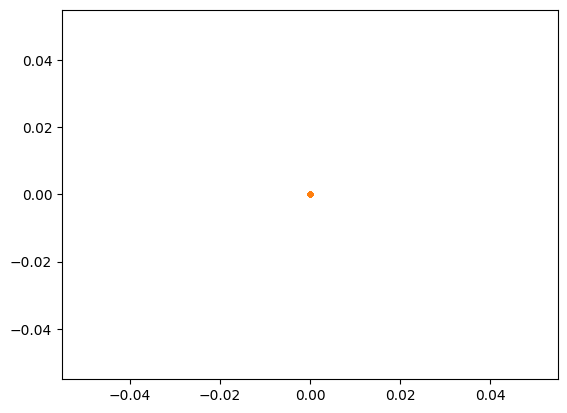

In [2]:
#@title 1D SE in a pixel phantom - sequence
# %% DEFINE the sequence, FOV and resolution
Nread=256
Nrep=10 # repeat the fid sequence mutiple times
TE=6e-3

experiment_id = 'se'
# %% SETUP system
# choose the scanner limits
system = mr.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=50 * 10e-6)
seq=mr.Sequence(system)

# Define rf event
# hard pulse for excitation
rf_ex = mr.make_block_pulse(flip_angle=90*np.pi/180, duration=1e-3, phase_offset=0*np.pi/180, delay=0e-3, system=system)
rf_ref = mr.make_block_pulse(flip_angle=90*np.pi/180, duration=1e-3, phase_offset=0*np.pi/180, delay=0e-3, system=system)

# Define ADC event
adc = mr.make_adc(num_samples=Nread, duration=51.2e-3, phase_offset=180*np.pi/180, delay=0e-3, system=system)
TE = 2*(adc.dwell*adc.num_samples/2+rf_ref.ringdown_time+rf_ref.shape_dur/2) # for echo in the middle of ADC

# Calcualte timing
delayTE1 = TE/2-rf_ex.shape_dur/2-rf_ex.ringdown_time-rf_ref.delay-rf_ref.shape_dur/2
delayTE2 = TE/2-rf_ref.shape_dur/2-rf_ref.ringdown_time-adc.delay-adc.dwell*adc.num_samples/2

# ======
# CONSTRUCT SEQUENCE
# ======
seq.add_block(rf_ex)
seq.add_block(mr.make_delay(delayTE1))
for i in range(Nrep):
  #seq.add_block(mr.make_delay(delayTE2))
  seq.add_block(rf_ref)
  seq.add_block(adc)

(ok, error_report) = seq.check_timing()  # Check whether the timing of the sequence is correct
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

# Plot k-space trajectory
k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()

plt.figure()
plt.plot(k_traj[0],k_traj[1])
plt.plot(k_traj_adc[0],k_traj_adc[1],'.')

# Prepare the sequence output for the scanner
seq.set_definition('Name', 'se')
seq.write('02_fid2se1d_solution.seq')

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


CustomVoxelPhantom
Voxel shape: box
Voxel size: tensor([0.1000, 0.1000, 0.1000])


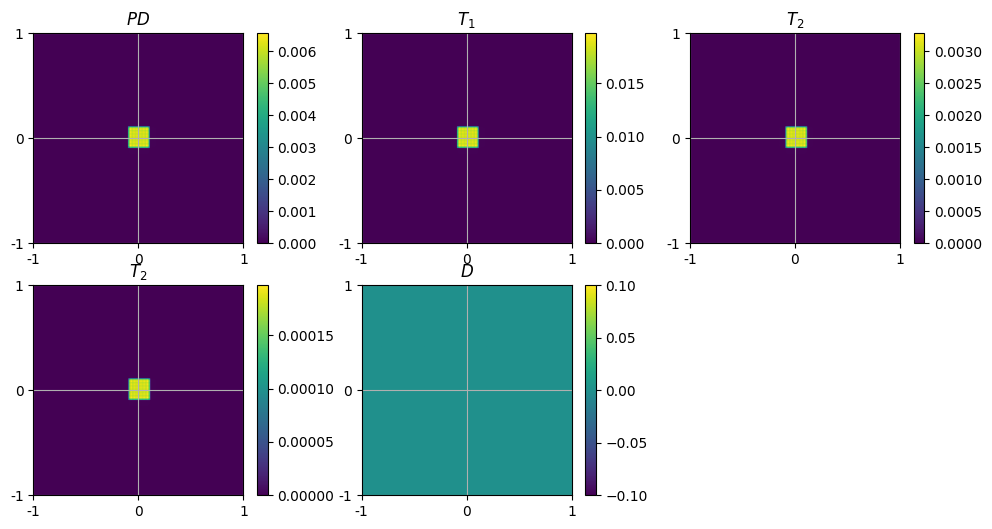

Some sections were ignored: ['SIGNATURE']
Calculating repetition 11 / 11 - done


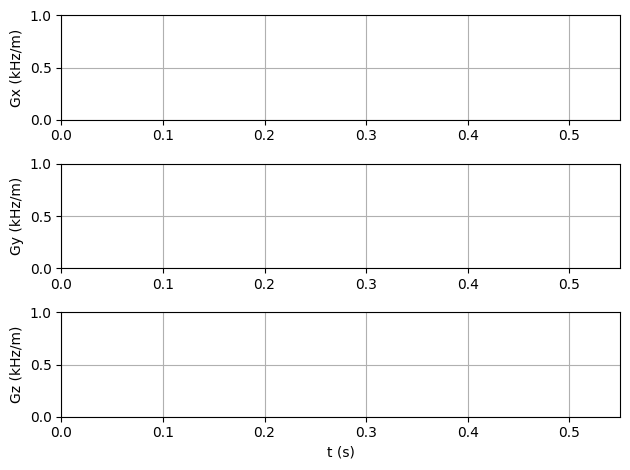

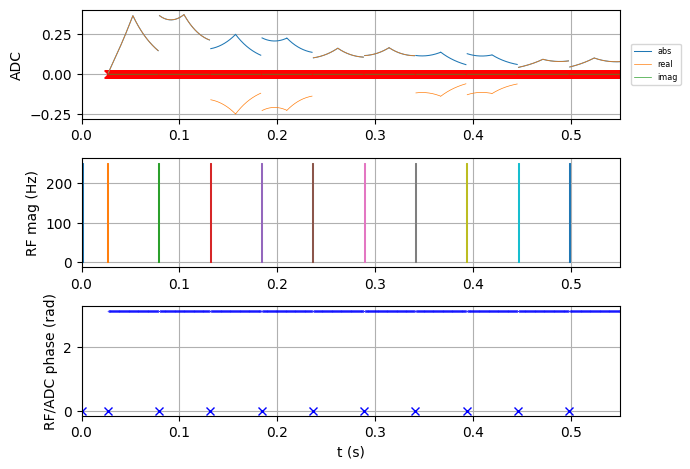

In [3]:
#@title 1D SE in a pixel phantom - simulation
dB0 = 0
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
# set phantom  manually to a pixel phantom. Coordinate system is [-0.5, 0.5]^3
obj_p = mr0.CustomVoxelPhantom(
        pos=[[0., 0., 0]],
        PD=[1.0],
        T1=[3.0],
        T2=[0.5],
        T2dash=[30e-3],
        D=[0.0],
        B0=0,
        voxel_size=0.1,
        voxel_shape="box"
    )
# Manipulate loaded data
obj_p.B0+=dB0
obj_p.D*=0
obj_p.plot()
# Convert Phantom into simulation data
obj_p=obj_p.build()

# %% SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.from_seq_file("02_fid2se1d_solution.seq")
#seq0.plot_kspace_trajectory()
# Simulate the sequence
graph=mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal=mr0.execute_graph(graph, seq0, obj_p)
# PLOT sequence with signal in the ADC subplot
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()

In [4]:
#@title 1D SE in a pixel phantom - reconstruction
# 1D FFT
def fft_1d(x):
    return np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(x)))

# detailed ADC plot for one repetition
if Nrep==1:
  plt.figure()
  plt.title('ADC signal')
  # time axis
  time_axis=np.linspace(1, Nread, Nread)*adc.dwell ;
  plt.plot(time_axis, np.real(signal), label='real')
  plt.plot(time_axis, np.imag(signal), label='imag')
  plt.plot(time_axis, np.abs(signal), label='abs')
  plt.grid()
  plt.legend(loc="upper right")
  plt.xlabel('time (ADC)/s')
  plt.ylabel('Amplitude')

  # FFT reconstruction
  spectrum = fft_1d(signal)

  # frequency axis
  freq_axis = np.linspace(-Nread/2, Nread/2-1, Nread)/(adc.dwell*adc.num_samples) ; # remain to be checked whether -1 should be included or not

  plt.figure()
  plt.title('spectrum')
  plt.plot(freq_axis, np.abs(spectrum))
  plt.xlabel('Frequency/Hz')
  plt.ylabel('Amplitude')